In [1]:
%matplotlib inline

In [2]:
ls

auxfilter.py   explore01-Copy1.ipynb  hardware.txt    matlabtools.pyc
auxfilter.pyc  explore01.ipynb        __init__.py     readme.md
bootstrap.py   feature.py             __init__.pyc    readme.me
bootstrap.pyc  fft_vectorize01.ipynb  matlabtools.py  Science.txt


In [3]:
import numpy as np, scipy as sp
import scipy.io
import scipy.signal as signal
import scipy.fftpack as ftpk
import matplotlib.pyplot as plt
import matplotlib

from imp import reload
import auxfilter
import matlabtools
import glob

In [4]:
matplotlib.style.use('ggplot')

In [5]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = slarge

Functions

Data loading section

In [6]:
basepath = '/home/mike/Downloads/train_1/'
path = basepath + '1_1_1.mat'
rawdata = matlabtools.get_matlab_eeg_data(path)
data = rawdata['data']
print(data.shape)
SR = rawdata['iEEGsamplingRate'][0][0]
if SR == int(SR):
    SR = int(SR)
print(SR)

(240000, 16)
400


In [7]:
data.shape

(240000, 16)

In [8]:
sig = data[:, 0]
fsig = ftpk.fft(data, axis=0)
t = np.linspace(0, 400, len(fsig))

fsig.shape


(240000, 16)

/home/mike/venvs/ml/ml/local/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


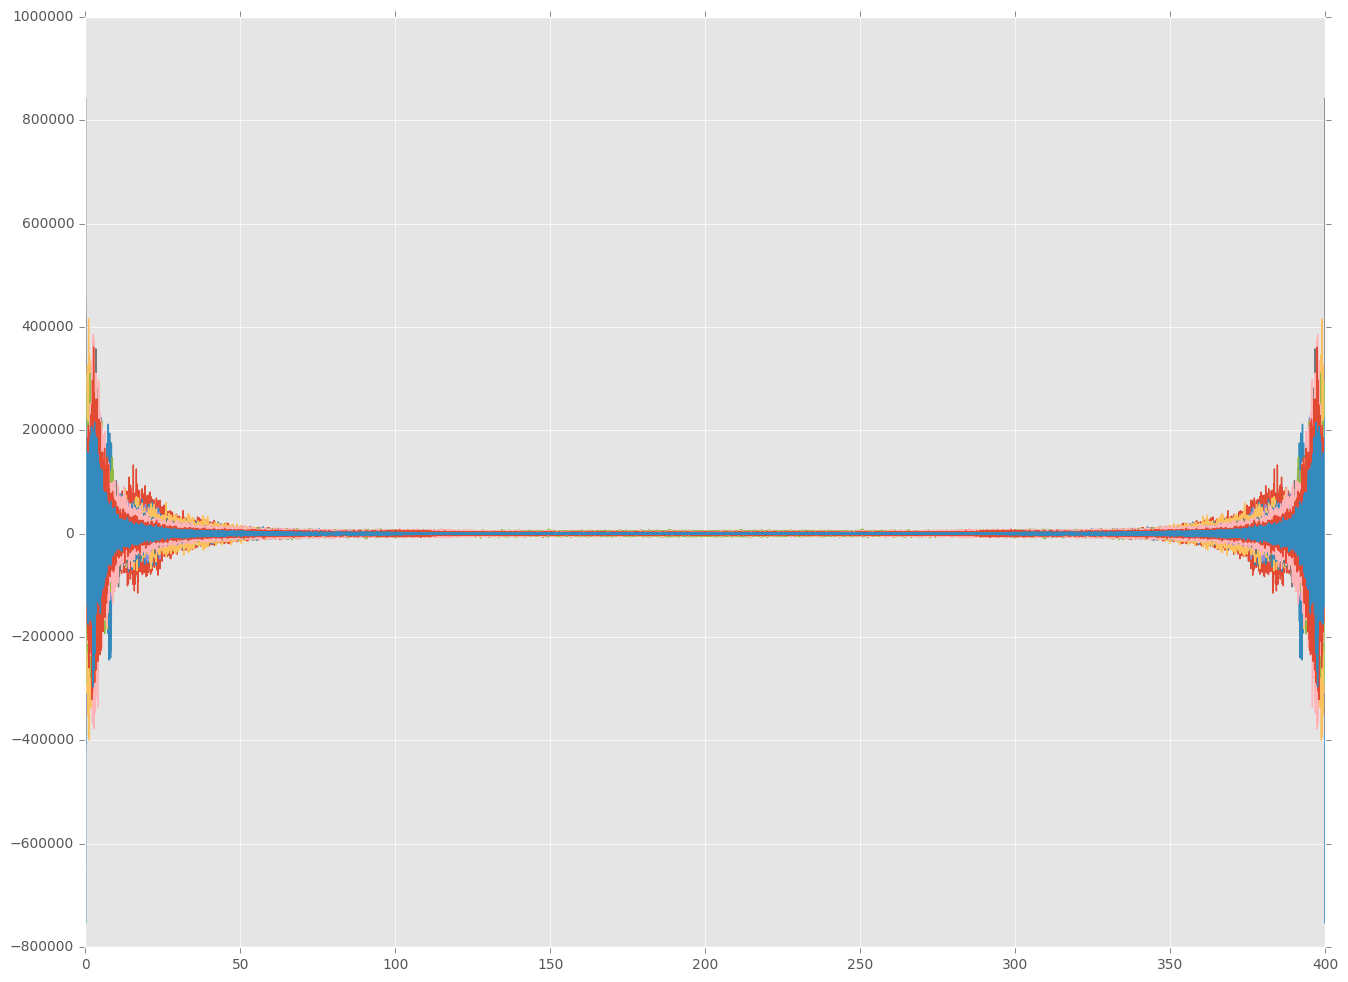

In [9]:
plt.plot(np.linspace(0, 400, len(fsig)), fsig)

In [10]:
def vectorize_fft(path, ndim=800, # number of vector dimensions to output
                  cutoff=40, # hard cutoff frequency
                  fs=400, # sample frequency of input signal
                  takeLog=True, # take log of freq spectrum
                  avgChan=False, # take average across all channels
                  stdChan=False, # take stdDev across all channels - VERY INTERESTING
                  sepComplex=False, # prolly don't need this
                  hilbertize=False): # don't need this right now
    rawdata = matlabtools.get_matlab_eeg_data(path)['data']
    spectrum = ftpk.fft(rawdata, axis=0)
    nsamp0 = rawdata.shape[0]
    t = np.linspace(0, fs, nsamp0)
    cutIndex = cutoff*nsamp0/fs
#     plt.plot(t[:cutIndex],np.abs(spectrum[:cutIndex]))
#     plt.plot(t, spectrum)
    if avgChan:
        spectrum = np.mean(spectrum, axis=1)
    elif stdChan:
        spectrum = np.std(spectrum, axis=1)
    rs_spectrum = signal.resample(np.abs(spectrum[:cutIndex]), ndim, axis=0)
    rs_t = np.linspace(0, cutoff, ndim)

#     print(rs_spectrum.shape)
#     print(np.angle(spectrum[:cutIndex]).shape)
#     plt.plot(t[:cutIndex], np.angle(spectrum[:cutIndex, 0]))
    """ Phase information at this point looks really nasty, so will ignore it"""

    if takeLog:
        rs_spectrum = np.log(rs_spectrum)
        
#     plt.plot(rs_t, rs_spectrum)
    return rs_spectrum



    


In [11]:
sources1 = glob.glob(basepath + '*_1.mat') 
sources0 = glob.glob(basepath + '*_0.mat') 


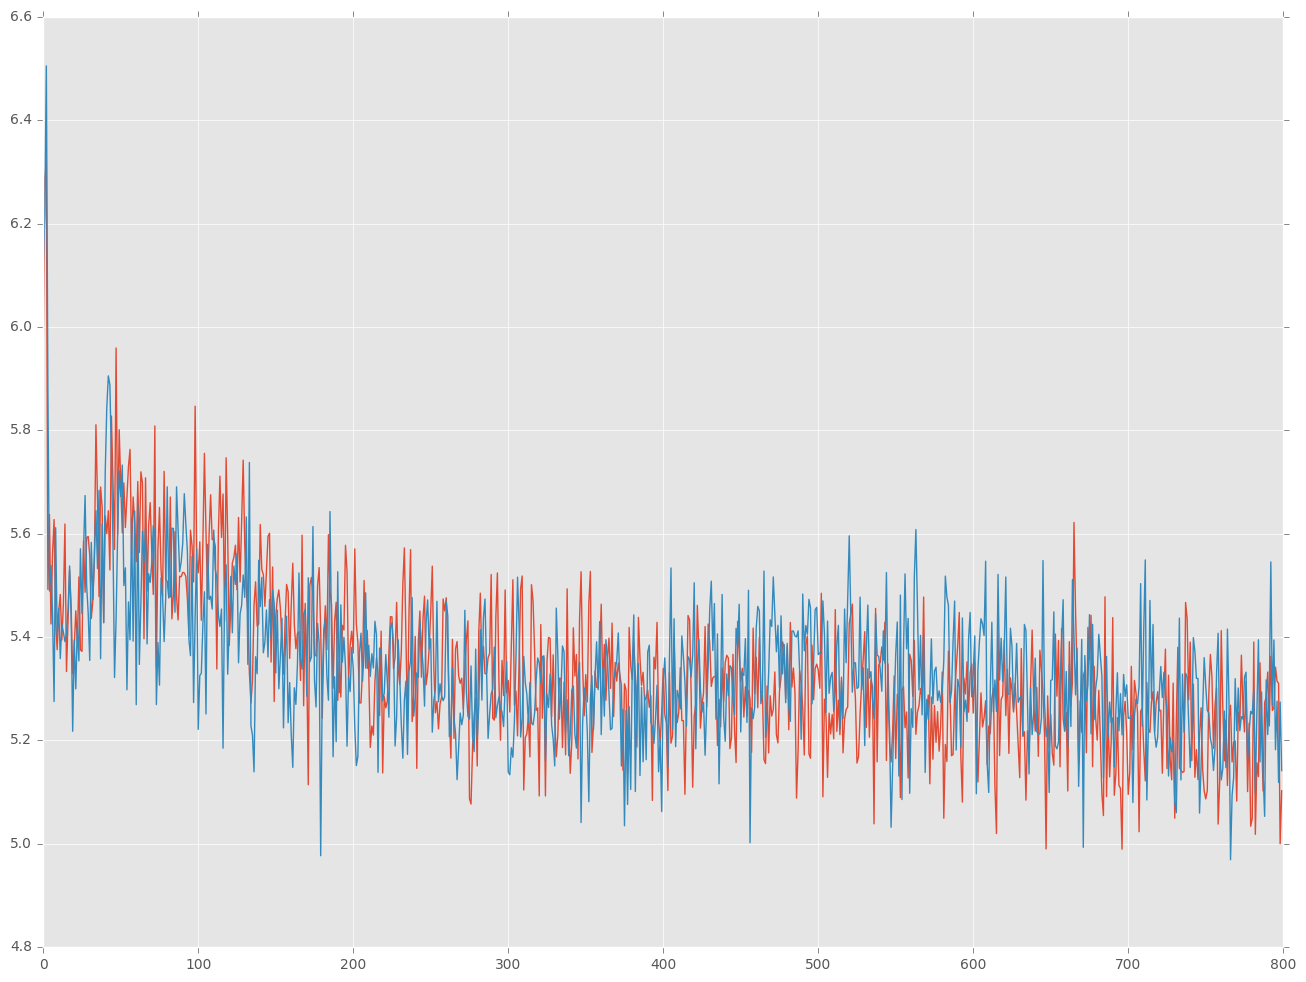

In [12]:
plt.plot(vectorize_fft(sources0[0], avgChan=1))
plt.plot(vectorize_fft(sources1[0], avgChan=1))

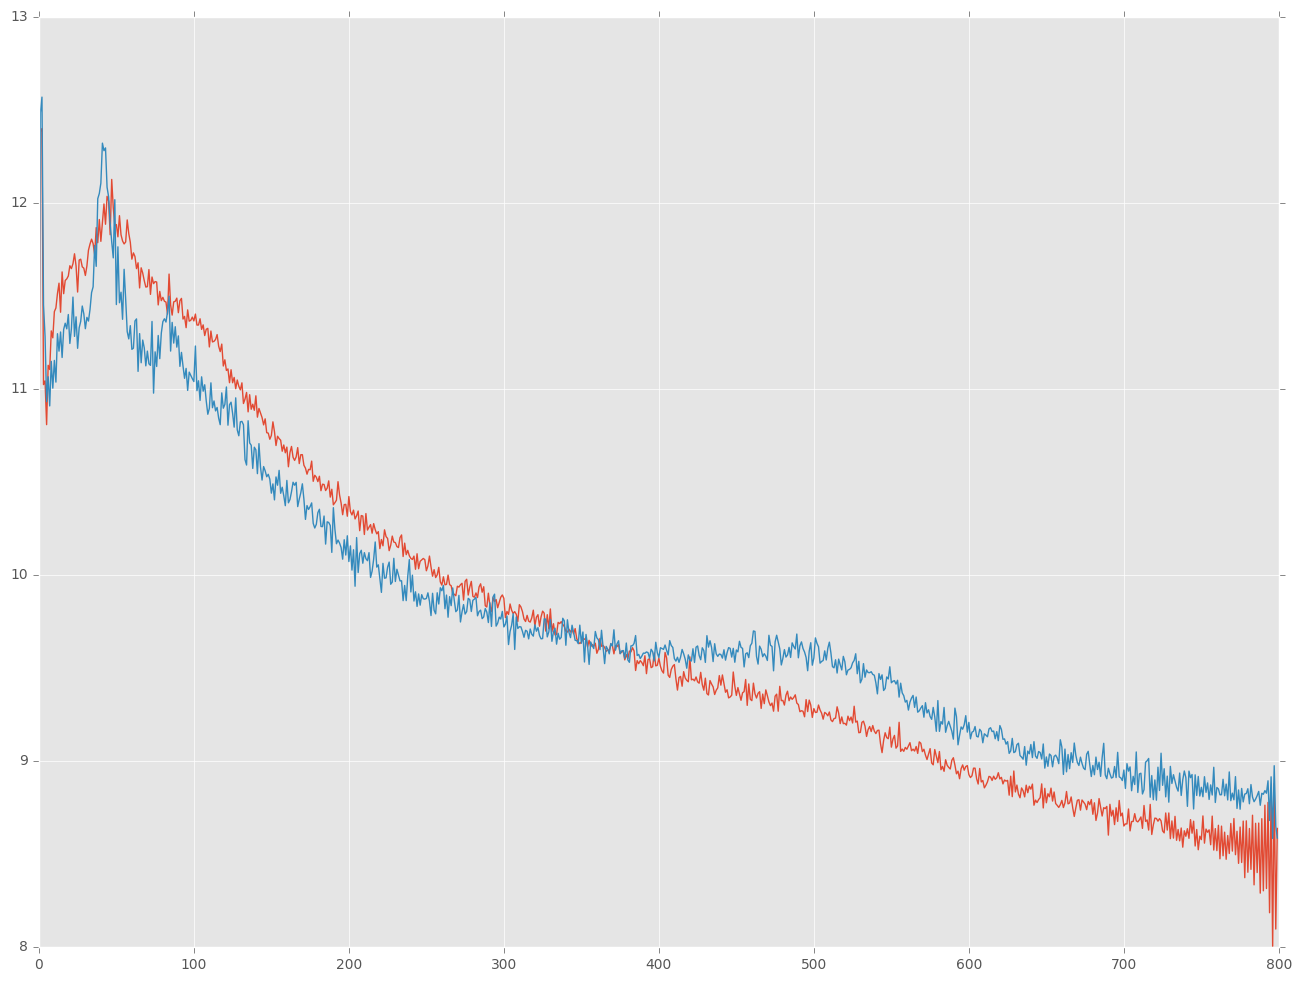

In [13]:
datanum = 0
plt.plot(vectorize_fft(sources0[datanum], stdChan=1))
plt.plot(vectorize_fft(sources1[datanum], stdChan=1))

Keras layer structure
option 1: take FFT, concat all the electrodes, feed into MLP (sigmoid). Dense 3 layer, 1-hot output. 
linearity bad. Reduce features (pca, smoothing, manual decimation) 
option 2: same, but with convo, max pooling instead of dimensionality reduction
option 3: noob feature vector maker (1600 per slice). feed into MLP as above.
option 4: NFV and use deep belief network (needs extensions)

In [35]:
spectra0 = []
spectra1 = []


In [36]:
for source in sources0:
    spectra0.append(np.nan_to_num(vectorize_fft(source, stdChan=1))) # this is not parallel
print("halfway done!")

/home/mike/venvs/ml/ml/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log
/home/mike/venvs/ml/ml/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log


halfway done!


In [37]:
for source in sources1:
    try:
        spectra1.append(np.nan_to_num(vectorize_fft(source, stdChan=1)))
    except:
        print("Bad:", source)

/home/mike/venvs/ml/ml/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log
/home/mike/venvs/ml/ml/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log


('Bad:', '/home/mike/Downloads/train_1/1_45_1.mat')


In [38]:
spectra0 = np.array(spectra0)
spectra1 = np.array(spectra1)

In [39]:
np.save("spectra1", spectra1)

In [52]:
flat0 = np.average(spectra0[:20], axis=0)
flat1 = np.average(spectra1[:20], axis=0)

flat0.shape


(800,)

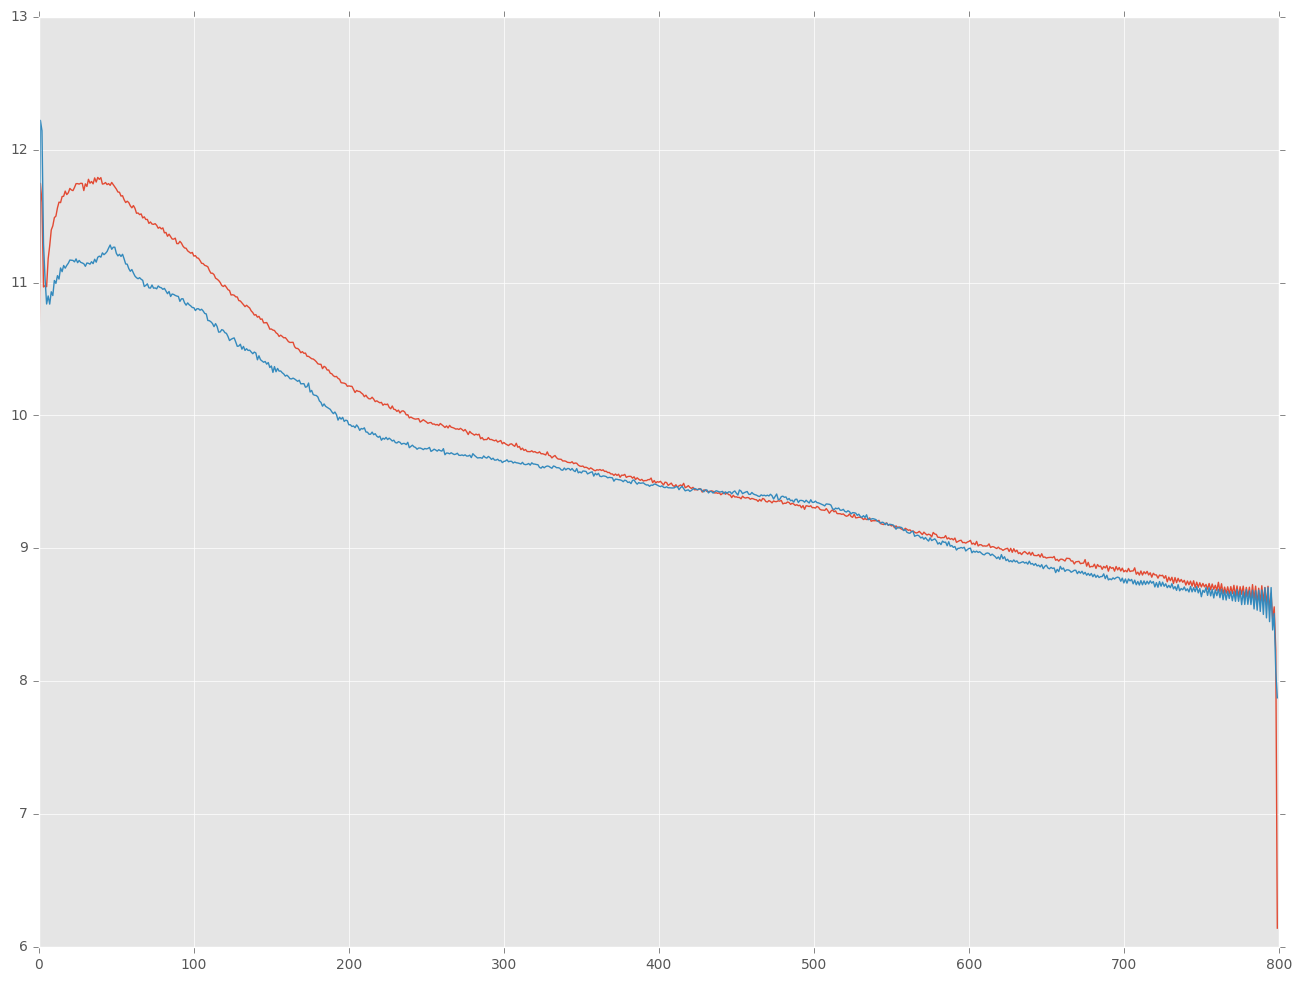

In [53]:
plt.plot(flat0)
plt.plot(flat1)
# flat0

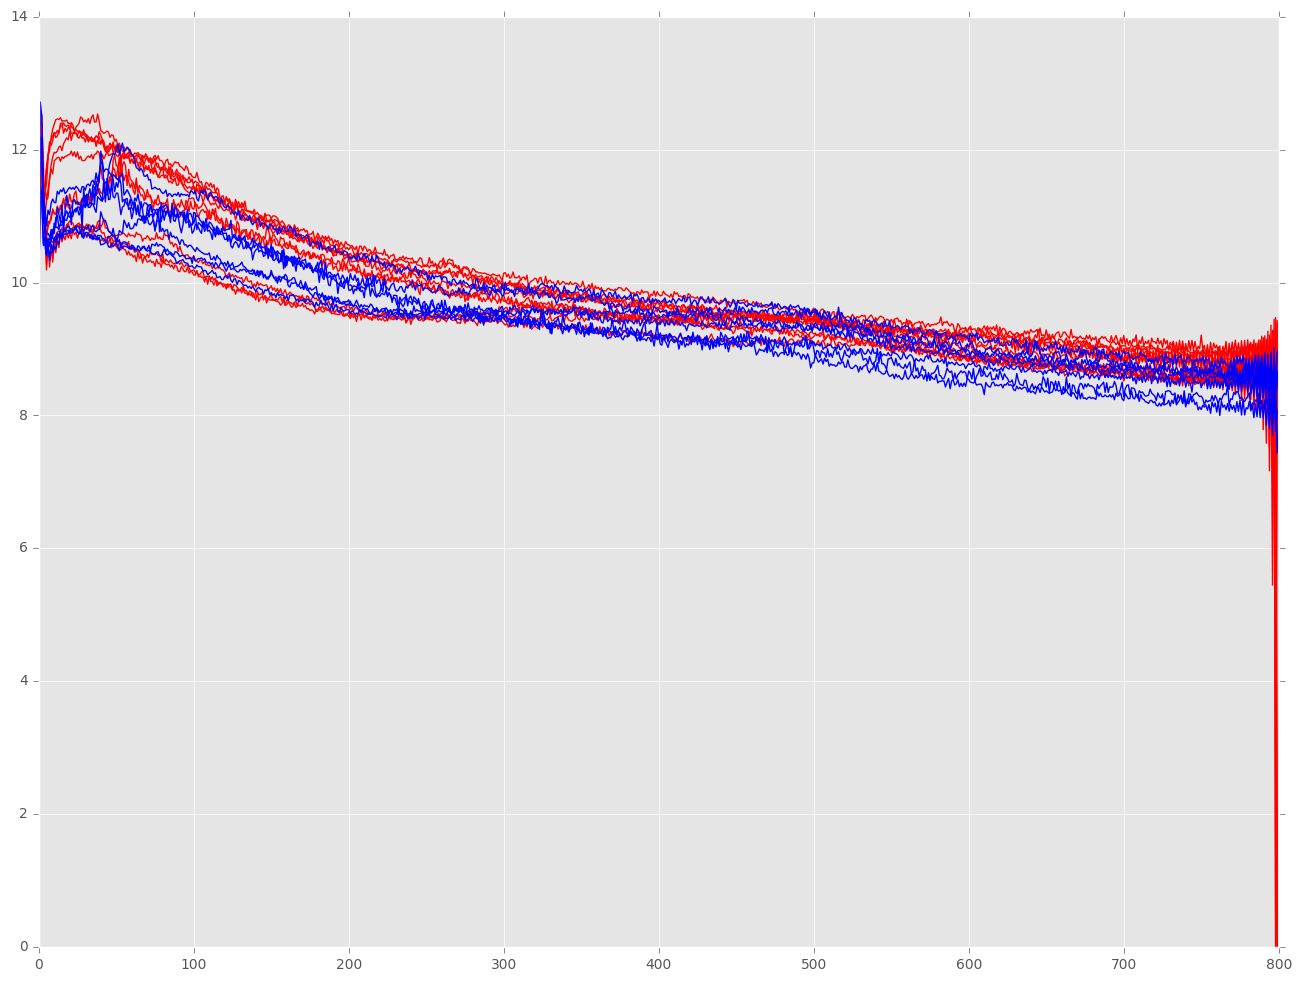

In [60]:
# I'm having a lot of issues combining the data for some reason. Not sure why, but i keep getting lots of overflow/underflow errors
a, b, c = 1, 200, 20
for i in range(a, b, c):
    try:
        plt.plot(spectra0[i], 'r')
    except:
        pass

for i in range(a,b,c):
    try:
        plt.plot(spectra1[i], 'b')
    except:
        pass
    
